# Multivariate Poisson Lognormal (MPLN) model
The MPLN model (?) relates some $p$-dimensional observation vectors $\boldsymbol{Y}_i$ to some $p$-dimensional vectors of Gaussian latent variables $Z_i$ as follows
$$
\begin{align}
& \boldsymbol{Y}_i\left|\boldsymbol{Z}_i \sim \operatorname{Poisson}\left(e^{Z_i}\right), \quad Y_{i j}\right| Z_{i j} \text { indep. } \\
& Z_i \sim \mathcal{N}\left(\boldsymbol{X}_i^{\top} \boldsymbol{B}_{d \times p}, \Sigma_{p \times p}\right)
\end{align}
$$

where
- $Y_{i j}$ represents the $j$ th code of $i$ th patient with $i=1, \cdots, n$ and $j=1, \cdots, p, \boldsymbol{Y}=\left(\boldsymbol{Y}_1, \cdots, \boldsymbol{Y}_n\right)^{\top} \in$ $\operatorname{Rn}^n \times p$
- $Z_i$ is the patient-level embedding of ith patient, $Z=\left(Z_1, \cdots, Z_n\right)^{\top} \in \mathbb{R}^{n \times p}$,
- $\boldsymbol{X}_i$ is the covariates of ith patient, $\boldsymbol{X}=\left(\boldsymbol{X}_1, \cdots, \boldsymbol{X}_n\right)^{\top} \in \mathbb{R}^{n \times d}$

## Leveraging external information for $\Sigma$
In the MPLN model, $\boldsymbol{\Sigma}$ describes the underlying residual relationships between the $p$ codes. We may decompose $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$, where $\boldsymbol{V} \in \mathbb{R}^{p \times q}$ is orthonormal and the rank $q \leq p, \boldsymbol{\Lambda} \in \mathbb{R}^{q \times q}$ is diagonal. Assuming that across different institution/dataset, the orientation/rotation $(\boldsymbol{V})$ is the same but the shape/scaling $\boldsymbol{\Lambda}$ can be different, we may borrow $\boldsymbol{V}$ that is obtained from external sources for model estimation. In that case, instead of estimating the full covariance matrix $\mathbf{\Sigma}$, we only need to estimate the diagnol matrix $\boldsymbol{\Lambda}$.


We now consider $V$ to be known: i.e., the parameters of the model are $B$ and $A$.

An alternative way to write the model:
$$
\begin{align}
& \boldsymbol{Y}_i\left|\boldsymbol{Z}_i \sim \operatorname{Poisson}\left(e^{Z_i}\right) \quad, \quad Y_{i j}\right| Z_{i j} \text { indep. } \\
& \boldsymbol{Z}_i={\boldsymbol{B}^\top\boldsymbol{X}_i + \boldsymbol{V} \boldsymbol{\Lambda}^{1 / 2}  \boldsymbol{W}_i } \quad, \\
& \boldsymbol{W}_i \sim \mathcal{N}\left(0_q, \boldsymbol{I}_{q \times q}\right) \quad \text { iid }
\end{align}
$$

(The equality with $\boldsymbol Z_i$ has been corrected from the original document).



## Joint likelihood
In matrix notation, $\boldsymbol{Z}=\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}$. The observation matrix $\boldsymbol{Y}$ only depends on $\boldsymbol{Z}$ through $\boldsymbol{B}, \boldsymbol{\Lambda}$ and $\boldsymbol{W}$, and the complete log-likelihood is therefore
$$
\begin{align}
\log p(\boldsymbol{Y}, \boldsymbol{W} ; \boldsymbol{B}, \boldsymbol{\Lambda})= & \sum_{i=1}^n \log p\left(\boldsymbol{Y}_i \mid \boldsymbol{W}_i ; \boldsymbol{B}, \boldsymbol{\Lambda}\right)+\log p\left(\boldsymbol{W}_i\right) \\
= & \mathbf{1}_n^{\top}\left\{\boldsymbol{Y} \odot\left(\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}\right)-\exp \left(\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}\right)\right\} \mathbf{1}_p \\
& -\frac{\|\boldsymbol{W}\|_F^2}{2}-\frac{n q}{2} \log (2 \pi)-\mathbf{1}_n^{\top} \log (\boldsymbol{Y} !) \mathbf{1}_p
\end{align}
$$

### Implementation details: Computing the MAP for W_i
The estimate for $W_i$ is the maximizer of the above joint loglihood. It is also called the maximum a posteriori (the MAP). By observational independence each $W_i$ can be computed individually. What's more, by conditional independence (on W_i), the joint log-likelihood for $(Y_i, W_i)$ is factorized as

$$
\log p(Y_i, W_i; B, A) = \sum_{j=1}^p \log p(y_{ij}|W_i;B, A) + \log p(W_i) 
$$

With derivative with respect to $W_i$ :

$$
\nabla_{W_i} = \frac{\partial }{\partial W_i}\log p(Y_i, W_i ; \boldsymbol{B}, \boldsymbol{\Lambda}) =\\ \sum_{j=1}^p A^{1/2} V_j (y_{ij} - \exp(x_{i}^\top\beta_j + W_i^\top A^{1/2}V_j)) - W_i
$$

in matrix notations:

$$
\nabla_{W_i} =   A^{1/2} V^\top(Y_i - \exp(B^\top x_i + V A^{1/2} W_i )) - W_i
$$

Here the role of "covariates" are taken by $VA^{1/2}$ and that of  "parameters" by the $W_i$, with a l2-norm penalty in the $W_i$.

The hessian is

$$
\nabla^2_{W_i} = - (A^{1/2} V^\top \text{diag}(\exp(B^\top x_i + V A^{1/2} W_i )) V A^{1/2} + I_q)
$$

Solving for $W_i$ can be done by Newton method: starting at some value $W_i^{(t)}$, the next iterate is given by


$$
W_i^{(t+1)} = W_i^{(t)} - [\nabla^2_{W_i}]^{-1} \nabla_{W_i}, 
$$

alternatively, IRLS could be used. Now, this needs to be done for every observation $i$. In our current implementation, we loop over all $W_i$. Optimally this should be vectorized. For instance, instead of computing a hessian matrix for all $i$, we can get its diagonal elements instead, and approximate the hessian by a diagonal matrix, yielding a quasi-newton method. These matrices are easy to obtain, specifically, the diagonal element $[\nabla^2_{W_i}]_{kk}$ is obtained as


$$
[\nabla^2_{W_i}]_{kk} = (A^{1/2} V_{\cdot k} \odot \mu_i ) ^\top A^{1/2} V_{\cdot k} \odot \mu_i  
$$

where $\mu_i = \exp(B^\top x_i + V A^{1/2} W_i ) $. The diagonal can be computed in a single step if necessary.

Alternatively, and with great success, one can use a neural network to impute the values for $W_i$, and learn it alongside $B$ and $A$.


### Further notes on implementation
* The $q\times q$ matrix $A$ is diagonal and its vector of diagonal elements $a$ has strictly positive elements. To implement this constraint, we do not estimate  $a$, but rather $\tilde a$ whose ith element is defined as the logarithm of $a_i$, i.e. $\tilde a_i = \log a_i$. (Note: this create some slight numerical issues for very small values of $a_i$, because its log is very large and negative, which is hard to attain using gradient descent (one would need second-order methods to speed it up). That being said, it shouldn't affect the results much).

# Preliminary Result: Example for setting 3.a.:

In [1]:
import sys
from pathlib import Path
import numpy as np
import torch
from torch.nn.utils import clip_grad_value_
from torch import nn
from sklearn.linear_model import PoissonRegressor
import matplotlib.pyplot as plt

sys.path.append(Path("low_rank_MPLN"))
import low_rank_MPLN


# Simulation setup
# --------------------
n = 5000  # number of observations
num_features = 50 
num_covariates = 1 # We include 1 intercept, presumably the "B" in the original docuzment. The true values of the corresponding coefficient is 0 here.
num_latents = 50 # We suppose full rank for both the true and estimated model

# Generate Sigma and obtain its eigendecomposition:
Sigma, V, a = low_rank_MPLN.gen_Sigma_AR1(num_features, rho=0.8)

# Generate the true model and sample some data
model_true = low_rank_MPLN.MPLN(num_latents, num_features, num_covariates, V[:,:num_latents], np.log(a[:num_latents]))
X = low_rank_MPLN.gen_X(n, num_covariates, intercept=True)
data = model_true.sample(n, X, poisson=True)

In [2]:
# Define the estimated model and train it
model = low_rank_MPLN.MPLN(num_latents, num_features, num_covariates, V[:,:num_latents])
fit = model.train_model(X, data, verbose=False, num_epochs=1000)

# Numerical Checks
Each of the following plot checks the convergence of our algorithm. We plot at each epoch t (or for every 10 epochs), the value of the parameter within our estimation algorithm.

### Checking the overall progress

To check for overall convergence, we first show the evolution of the estimates across all iterations (one value every 10 iterations is displayed here).

For A:

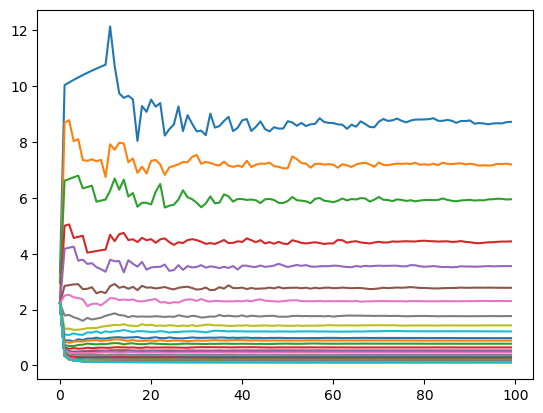

In [3]:
_ = plt.plot(np.exp(fit['A_hist']))

For B:

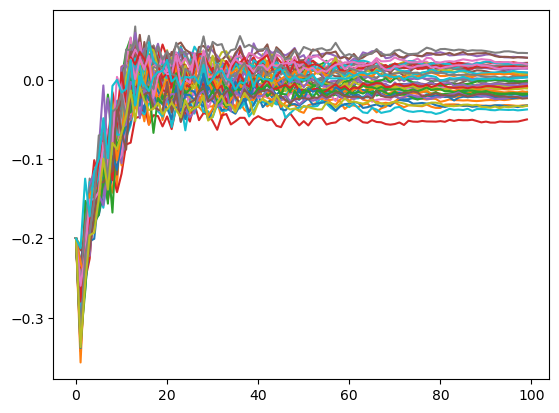

In [4]:
_ = plt.plot(fit['B_hist'])

### Checking convergence
To check for stability, we now plot the last 50 iteration values. A possibility is to take their average as an estimtor (This is Polyak averaging).

For A:

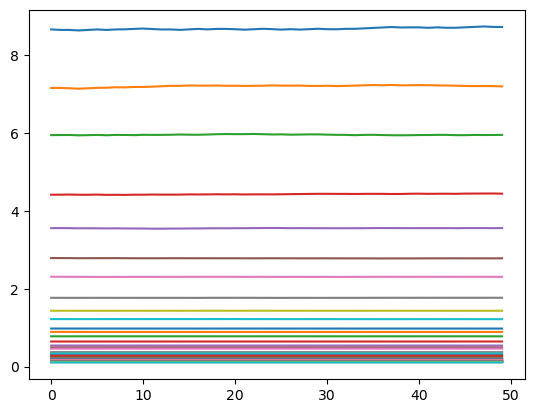

In [5]:
# Plot the last 50 iterations of A 
_ = plt.plot(np.exp(fit['A_last']))

For B:

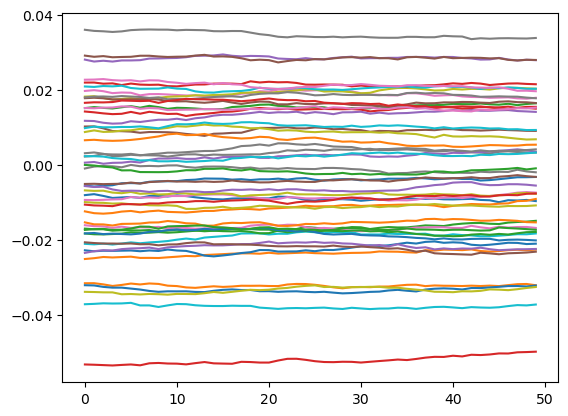

In [6]:
# Plot the last 50 values of B
_ = plt.plot(fit['B_last'])

The algorithm seems to be converging fine. We notice a higher variance for the updates for B, which can be solved by defining a separate learning rate for this group. This is of little consequence for now.

# Statistical Checks

We now check the estimation of the parameters $a$ and $B$.

### Plot of $a$ against $\hat a$

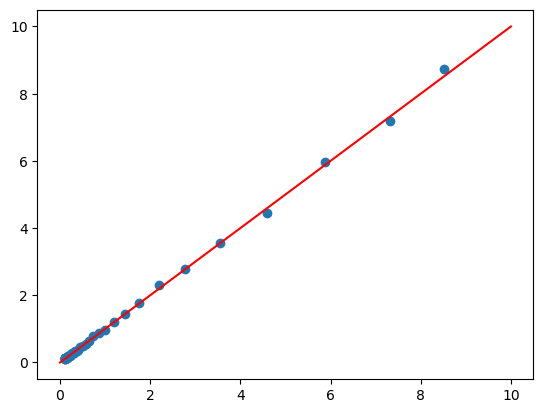

In [7]:
plt.scatter(torch.exp(model_true.a).detach().numpy(), torch.exp(model.a).sort(descending=True)[0].detach().numpy())
plt.plot([0,10], [0, 10], color="red")

It seems fine on this one simulation, but we need more to check the sampling properties of our estimator.

# Re-compose the Estimated Matrix

The estimated matrix is $\hat\Sigma = V \hat A V^\top$. We can plot each elements of $\hat\Sigma$ against the corresponding element of $\Sigma$:

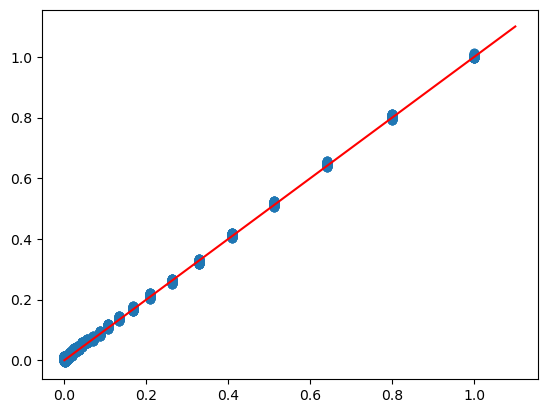

In [8]:
S = low_rank_MPLN.compute_Sigma(V=V, a=np.exp(fit['A_last_avg']))
plt.scatter(Sigma, S)
plt.plot([0,1.1], [0,1.1], color="red")

# "Bias" of the estimated intercepts $B$

The "bias" is in quotations marks since this is from only one simulation only and therfore does not represent the sampling properties of our estimator. However, since all intercepts are 0, we can still display these estimates as a boxplot to check for potential issues with the estimator / algorithm. We also draw the mean as a red diamond.

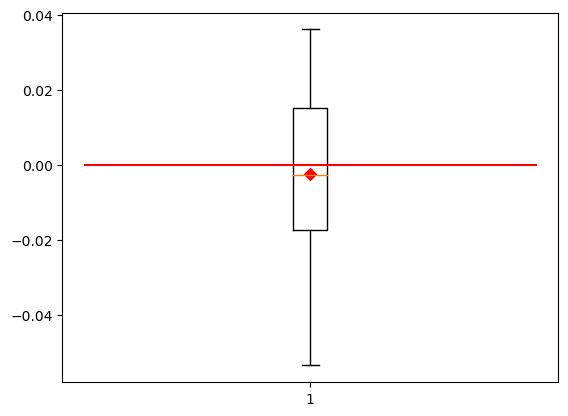

In [9]:
B = fit['B_last'].flatten()

plt.boxplot(B)
plt.scatter(1, np.mean(B), marker='D', color="red")
plt.plot([0,2], [0,0], color="red")

It seems fine, but a simulation study would be necessary to understand the bias properties.

## Moving Forward: Simulations
### 2.4 Simulation setting
The following simulation settings are taken from the original document.

Let $n=5000, p=50$. Consider two scenarios: true covariance has full rank and has low rank.

- Scenario 1 (true covariance with full rank):
1. Generate $\boldsymbol{\Sigma}=A R_1(0.8)$. Find its eigen-decomposition $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$. 
2. Generate $\boldsymbol{Z} \sim \mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$ and $\boldsymbol{Y} \sim \operatorname{Poisson}\left(e^{\boldsymbol{Z}}\right)$.
3. Fit model with $\boldsymbol{V}$,

    a. (correct) assuming $\boldsymbol{\Sigma}$ has full rank, $\boldsymbol{\Lambda} \in \mathbb{R}^{p \times p}$, we use the full $\boldsymbol{V}$ here.
    
    b. (low rank appriximation) assuming $\boldsymbol{\Sigma}$ has lower rank, $\Lambda \in \mathbb{R}^{q \times q}$ with $q=20,10,5$, we only use $\boldsymbol{V}_{[, 1: q]}$ here.

- Scenario 2 (true covariance with low rank, $q=12$ ):
1. Generate $\boldsymbol{\Sigma}=A R_1(0.8)$. Find its eigen-decomposition $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$.
2. Let $\tilde{\boldsymbol{\Sigma}}=\boldsymbol{V}_{[, 1: q]} \boldsymbol{\Lambda}_{[1: q, 1: q]} \boldsymbol{V}_{[, 1: q]}^T$. Find its eigen-decomposition $\tilde{\mathbf{\Sigma}}=\tilde{\boldsymbol{V}} \tilde{\boldsymbol{\Lambda}}^{\top}$. This will be our true covariance with known rank $=q$. (In reality we observe $\bar{\Sigma}$ from external sources)
4. Fit model with $\vec{V}$.
a. (neglecting low-rankness) assuming $\Sigma$ has full rank, $\Lambda \in \mathbb{R}^{p \times p}$, we use the full $\tilde{V}$ here.
b. (correct) assuming $\Sigma$ has lower rank, $\Lambda \in \mathbb{R}^{q \times q}$ with $q=20,10,5$, we only use $\tilde{\boldsymbol{V}}_{[, 1: q]}$. here. (In reality we don't know the true rank, so would also need to implement a procedure to select for the best $q$.


## Questions for The Simulations
- Just to confirm: $AR_1(0.8)$ refers to the matrix of auto-correlation of an AR(1) process with auto-correlation coefficient $\rho=0.8$, correct?
- We would like to reproduce Figure 2 (or Figure 3) to check for the potential bias of our above estimator (is that indeed the goal?). These figures show the bias of two estimators for $B$. However, $B$ has been defined as the matrix of coefficients for the covariates (and intercept), but these were not defined in the above simulations setting (rather, they are not included and the intercepts are set to 0). If there are indeed covariates, how are they simulated?
- What exactly is $B$ in Figures 2 and 3? If this represents the estimator of $B=0$, what particulr element is displayed? In short, what estimated element of $B$, $A$ or $\Sigma$ should be displayed? (Since the dimension of $A$ is not always the same between the estimated model and the truth, it is not always possible to directly compare their values. What exactly should be compared then?)

Thank you!
